## Imports and Functions

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import glob, json
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%cd /content/drive/MyDrive/11797

/content/drive/.shortcut-targets-by-id/1MFf3kaD46sxRX3TIjDW2dPZaUByAQpJ3/11797


In [3]:
def collate_processed_train(train_data, verbose=0):
    final_train_data = {}
    for datum in train_data:
        real_id = datum['id'].split('_')[0]
        final_train_data[real_id] = final_train_data.get(real_id, {})
        qtype = datum['type']
        prev_ans = set(final_train_data[real_id].get('exact_answer', set()))
        prev_ans.add(datum['answers']['text'][0])
        final_train_data[real_id] = {
            'id': real_id,
            'type': qtype,
            'exact_answer': list(prev_ans)
        }
    final_train_data = list(final_train_data.values())
    if verbose>0: print(f'{len(final_train_data)} datapoints extracted')
    return final_train_data

In [4]:
def compute_metrics(final_answers_path, train_data_path, cnt_threshold=100, prob_threshold=0, verbose=0):
    with open(final_answers_path, 'r') as f1, open(train_data_path, 'r') as f2:
        final_answers = json.load(f1)
        train_data = collate_processed_train(json.load(f2)['data'], verbose)

    if verbose == 2: print(json.dumps(train_data[:3], indent=4))

    strict, lenient = 0, 0
    precision_list, recall_list, f1_list = [], [], []
    mrr_list = []
    list_ctr, fact_ctr = 0, 0

    for train_datum in train_data:
        if train_datum['id'] not in final_answers:
            continue

        if train_datum['type'] == 'list':
            exact_ans = set(train_datum["exact_answer"])
            # exact_ans = set([item for sublist in exact_ans for item in sublist])
            predicted_ans = [  answer['text'] for answer in sorted(final_answers[train_datum['id']], key=lambda x: x['probability'], reverse=True) if answer['probability']>prob_threshold  ]
            predicted_ans = set(predicted_ans[:cnt_threshold])

            if verbose==2:
                print('List'.ljust(8), exact_ans, predicted_ans)

            tp = len(exact_ans.intersection(predicted_ans))
            fp = len(predicted_ans.difference(exact_ans))
            fn = len(exact_ans.difference(predicted_ans))
            precision = tp/(tp+fp) if tp+fp > 0 else 0
            recall = tp/(tp+fn) if tp+fn > 0 else 0
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append((2*precision*recall)/(precision+recall) if precision+recall > 0 else 0)
            list_ctr+=1

        elif train_datum['type'] == 'factoid':
            assert len(train_datum["exact_answer"]) == 1, train_datum["exact_answer"]
            exact_ans = train_datum["exact_answer"].pop()
            predicted_ans = [answer['text'] for answer in final_answers[train_datum['id']]]

            if verbose==2:
                print('Factoid'.ljust(8), exact_ans, predicted_ans)

            if predicted_ans[0] == exact_ans:
                strict+=1
            if exact_ans in predicted_ans[:5]:
                lenient+=1
                mrr_list.append(1 / (1+predicted_ans.index(exact_ans)))
            else: mrr_list.append(0)
            fact_ctr+=1

    assert list_ctr + fact_ctr == len(final_answers)
    avg_pr = np.mean(np.array(precision_list))
    avg_re = np.mean(np.array(recall_list))
    avg_f1 = np.mean(np.array(f1_list))
    avg_mrr = np.mean(np.array(mrr_list))

    if verbose==1:
        print('Eval'.ljust(10), '-', len(final_answers), 'data points')
        print('Precision'.ljust(10), '-', round(avg_pr, 4))
        print('Recall'.ljust(10), '-', round(avg_re, 4))
        print('F1'.ljust(10), '-', round(avg_f1, 4))
        print('MRR'.ljust(10), '-', round(avg_mrr, 4))

    return round(avg_pr, 4), round(avg_re, 4), round(avg_f1, 4), round(avg_mrr, 4)

In [5]:
def truncate(final_answers, cnt, prob):
    truncated = dict()
    for k, v in final_answers.items():
        truncated[k] = sorted([elem for elem in v if elem['probability']>prob], key=lambda x: x['probability'], reverse=True)[:cnt]
    return truncated

## Main

In [ ]:
# files = sorted(glob.glob('postprocess_results/bioe*/*.json'))[1:]
files = sorted(glob.glob('*_v2/final_answers_0.0.json'))[1:]
results = []

for file in files:
    with open(file, 'r') as f:
        results.append(json.load(f))
    print(file)
    res = compute_metrics(file, 'train_file.json', verbose=1)
    print('\n\n')

biobert_base_11b_v2/final_answers_0.0.json
1721 datapoints extracted
Eval       - 345 data points
Precision  - 0.16
Recall     - 0.7036
F1         - 0.2326
MRR        - 0.6314



bioelectra_base_11b_v2/final_answers_0.0.json
1721 datapoints extracted
Eval       - 345 data points
Precision  - 0.1857
Recall     - 0.7286
F1         - 0.2711
MRR        - 0.6885





In [ ]:
for fname in files:
    f1s, max_f1 = [], 0
    print('\n', fname)

    cnts_range = range(1, 15)
    prob_range = np.linspace(0, 1, 200+1)

    pbar = tqdm(total=len(cnts_range)*len(prob_range), dynamic_ncols=True, desc=f'Max F1 = {max_f1:.4f}')
    for cnt in cnts_range:
        for prob in prob_range:
            p, r, f, m = compute_metrics(fname, 'train_file.json', cnt, prob, 0)
            f1s.append([cnt, prob, p, r, f, m])
            pbar.update(1)
            max_f1 = max(max_f1, f)
            pbar.set_description(f'Max F1 = {max_f1:.4f}')
    print('P Sorted -', sorted(f1s, key=lambda x: x[-4], reverse=True)[:5])
    print('R Sorted -', sorted(f1s, key=lambda x: x[-3], reverse=True)[:5])
    print('F Sorted -', sorted(f1s, key=lambda x: x[-2], reverse=True)[:5])
    print('M Sorted -', sorted(f1s, key=lambda x: x[-1], reverse=True)[:5])
    print()

    del pbar

In [ ]:
truncated_results = []
truncated_results.append(truncate(results[0], 7, 0.055))
truncated_results.append(truncate(results[1], 10, 0.055))

In [ ]:
weights_ablations = []
# w1_range = np.linspace(0, 1, 50+1)
# w2_range = np.linspace(0, 1, 50+1)
max_f1 = 0

try: del pbar
except: pass

# pbar = tqdm(total=len(w1_range)*len(w2_range), dynamic_ncols=True, desc=f'Ensemble Max F1 = {max_f1:.4f}')
# ['biobert_base_11b_v2/final_answers_0.0.json', 'bioelectra_base_11b_v2/final_answers_0.0.json']
# for w1 in w1_range:
#     for w2 in w2_range:
# for w1 in tqdm(np.linspace(0, 1, 1000+1)):
for w1 in tqdm([0, 1]):
        combined_results_df = pd.DataFrame()
        weights = [w1, 1-w1]
        for final_data, weight in zip(truncated_results, weights):
            final_data_df = pd.DataFrame([(k, *v.values()) for k, v in final_data.items() for v in v], 
                    columns=['key', 'start_logit', 'end_logit', 'text', 'probability'])
            final_data_df['probability'] *= weight
            combined_results_df = pd.concat([combined_results_df, final_data_df])
        combined_results_df = combined_results_df.groupby(['key', 'text']).sum().reset_index().sort_values('key probability'.split(), ascending=False)
        combined_results = combined_results_df.groupby('key').apply(lambda x: x[['start_logit', 'end_logit', 'text', 'probability']].to_dict('records')).to_dict()
        with open('/content/weight_ablations_data.json', 'w') as f: json.dump(combined_results, f, indent=4)
        res_metrics = compute_metrics('/content/weight_ablations_data.json', 'train_file.json')
        weights_ablations.append([*weights, *res_metrics])
        max_f1 = max(max_f1, res_metrics[-2])
        # pbar.set_description(desc=f'Ensemble Max F1 = {max_f1:.4f}')

p_best = sorted(weights_ablations, key=lambda x: x[-4], reverse=True)
r_best = sorted(weights_ablations, key=lambda x: x[-3], reverse=True)
f1_best = sorted(weights_ablations, key=lambda x: x[-2], reverse=True)
mrr_best = sorted(weights_ablations, key=lambda x: x[-1], reverse=True)

print()
print('P   Best/Worst', p_best[0][-4]  , p_best[-1][-4])
print('R   Best/Worst', r_best[0][-3]  , r_best[-1][-3])
print('F1  Best/Worst', f1_best[0][-2] , f1_best[-1][-2])
print('MRR Best/Worst', mrr_best[0][-1], mrr_best[-1][-1])

  0%|          | 0/2 [00:00<?, ?it/s]


P   Best/Worst 0.5331 0.4956
R   Best/Worst 0.6474 0.5768
F1  Best/Worst 0.5504 0.4914
MRR Best/Worst 0.6862 0.6488


In [ ]:
weights_ablations

[[0, 1, 0.5331, 0.6474, 0.5504, 0.6862],
 [1, 0, 0.4956, 0.5768, 0.4914, 0.6488]]

In [ ]:
mrr_best[0]

[0.037, 0.963, 0.4748, 0.7375, 0.5374, 0.6969]

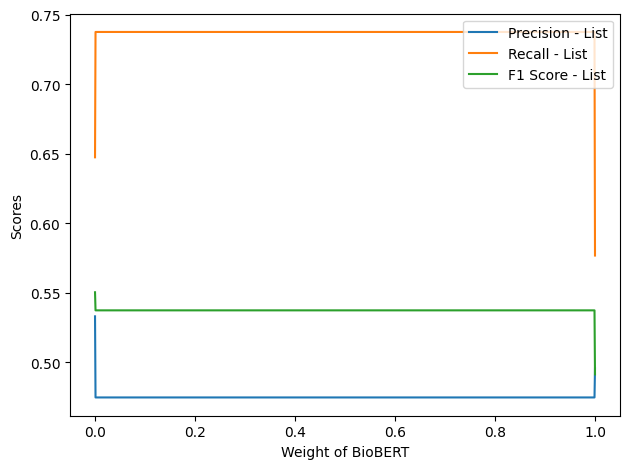

In [ ]:
plt.plot([i[0] for i in weights_ablations], [i[-4] for i in weights_ablations], label='Precision - List')
plt.plot([i[0] for i in weights_ablations], [i[-3] for i in weights_ablations], label='Recall - List')
plt.plot([i[0] for i in weights_ablations], [i[-2] for i in weights_ablations], label='F1 Score - List')
# plt.plot([i[0] for i in weights_ablations], [i[-1] for i in weights_ablations], label='MRR Score - Factoid')
# plt.ylim(0.48, 0.56)
plt.legend(loc='upper right')
plt.xlabel('Weight of BioBERT')
plt.ylabel('Scores')
plt.tight_layout()
plt.savefig(f'/content/List Analysis.png')
plt.show()

In [ ]:
f1_best[:5], mrr_best[:5]

([[0.0, 1.0, 0.5331, 0.6474, 0.5504, 0.6862],
  [0.001, 0.999, 0.4748, 0.7375, 0.5374, 0.688],
  [0.002, 0.998, 0.4748, 0.7375, 0.5374, 0.691],
  [0.003, 0.997, 0.4748, 0.7375, 0.5374, 0.691],
  [0.004, 0.996, 0.4748, 0.7375, 0.5374, 0.691]],
 [[0.037, 0.963, 0.4748, 0.7375, 0.5374, 0.6969],
  [0.038, 0.962, 0.4748, 0.7375, 0.5374, 0.6969],
  [0.039, 0.961, 0.4748, 0.7375, 0.5374, 0.6969],
  [0.04, 0.96, 0.4748, 0.7375, 0.5374, 0.6969],
  [0.041, 0.959, 0.4748, 0.7375, 0.5374, 0.6969]])

## Predict Files

In [20]:
with open('yesno/predict_results_batch2.txt', 'r') as f:
    yesno_predictions = [i.split('\t') for i in f.readlines()]

yesno_predictions = {k.strip(): v.strip() for k, v in yesno_predictions[1:] }
len(yesno_predictions)

24

In [21]:
files = sorted(glob.glob('*_v2_test_2/final_answers_predict_0.0.json'))
results = []

for file in files:
    with open(file, 'r') as f:
        results.append(json.load(f))
    print(file)

truncated_results = []
truncated_results.append(truncate(results[0], 7, 0.055))
truncated_results.append(truncate(results[1], 10, 0.055))

biobert_base_11b_v2_test_2/final_answers_predict_0.0.json
bioelectra_base_11b_v2_test_2/final_answers_predict_0.0.json


In [26]:
# w1, w2 = 0.004, 0.996
w1, w2 = 0.037, 0.963
combined_results_df = pd.DataFrame()
weights = [w1, w2]
for final_data, weight in zip(truncated_results, weights):
    final_data_df = pd.DataFrame([(k, *v.values()) for k, v in final_data.items() for v in v], 
            columns=['key', 'start_logit', 'end_logit', 'text', 'probability'])
    final_data_df['probability'] *= weight
    combined_results_df = pd.concat([combined_results_df, final_data_df])
combined_results_df = combined_results_df.groupby(['key', 'text']).sum().reset_index().sort_values('key probability'.split(), ascending=False)
our_results = combined_results_df.groupby('key').apply(lambda x: x[['start_logit', 'end_logit', 'text', 'probability']].to_dict('records')).to_dict()

## Submission File Write

In [17]:
# model = 'bioelectra'
# truncate_length = 10
# batch = '2'
# test_file = f'test/BioASQ-task11bPhaseB-testset{batch}.json'
# our_results = f'{model}_base_11b_v2_test_2/final_answers_predict_0.0.json'
# save_file = f'test/{model}_batch{batch}.json'

# our_results = json.load(open(our_results, 'r'))
# our_results = truncate(our_results, truncate_length, 0.055)
# test_file = json.load(open(test_file, 'r'))

# len(our_results), len(test_file['questions'])

(34, 75)

In [27]:
batch = '2'
test_file = f'test/BioASQ-task11bPhaseB-testset{batch}.json'
save_file = f'test/ensemble_batch{batch}_{w1}_{w2}.json'

test_file = json.load(open(test_file, 'r'))

len(our_results), len(test_file['questions'])

(34, 75)

In [28]:
for idx, question in enumerate(test_file['questions']):
    if question['type'] == 'factoid':
        ans = sorted(our_results[question['id']], key=lambda x: x['probability'], reverse=True)[:5]
        ans = [ [i['text']] for i in ans ]
        question['ideal_answer'] = ""
        question['exact_answer'] = ans
        test_file['questions'][idx] = question

    elif question['type'] == 'list':
        ans = sorted(our_results[question['id']], key=lambda x: x['probability'], reverse=True)
        ans = [[i['text']] for i in ans]
        question['ideal_answer'] = ""
        question['exact_answer'] = ans
        test_file['questions'][idx] = question

    elif question['type'] == 'yesno':
        ans = yesno_predictions[question['id']]
        question['ideal_answer'] = ""
        question['exact_answer'] = ans
        test_file['questions'][idx] = question

    else:
        ans = ""
        question['ideal_answer'] = ans
        test_file['questions'][idx] = question

In [29]:
with open(save_file, 'w') as f: json.dump(test_file, f, indent=4)

## Plots

<Figure size 864x432 with 0 Axes>

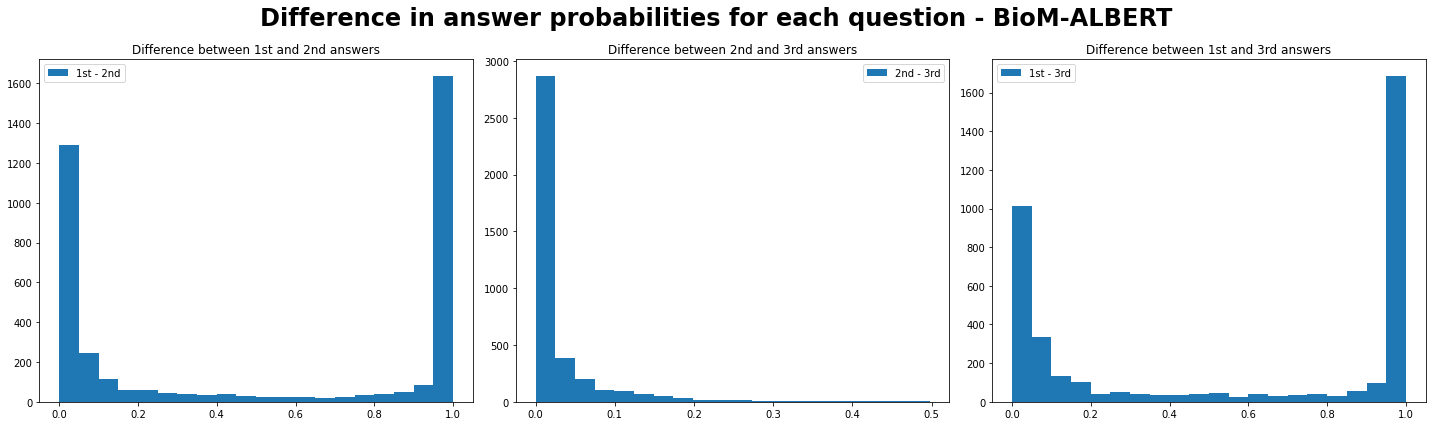

In [ ]:
plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

diffs12 = []
diffs23 = []
diffs13 = []

model = 'BioM-ALBERT'
for qid, answer in results[2].items():
    try:
        diffs12.append(answer[0]['probability'] - answer[1]['probability'])
        diffs23.append(answer[1]['probability'] - answer[2]['probability'])
        diffs13.append(answer[0]['probability'] - answer[2]['probability'])
    except: continue
    
ax[0].hist(diffs12, bins=20, alpha=1, label='1st - 2nd')
ax[1].hist(diffs23, bins=20, alpha=1, label='2nd - 3rd')
ax[2].hist(diffs13, bins=20, alpha=1, label='1st - 3rd')

ax[0].set_title('Difference between 1st and 2nd answers')
ax[1].set_title('Difference between 2nd and 3rd answers')
ax[2].set_title('Difference between 1st and 3rd answers')

ax[0].legend()
ax[1].legend()
ax[2].legend()

title = fig.suptitle(f'Difference in answer probabilities for each question - {model}')
title.set_fontsize(24)
title.set_weight('bold')
fig.tight_layout()

plt.savefig(f'/content/{model}.png')

plt.show()

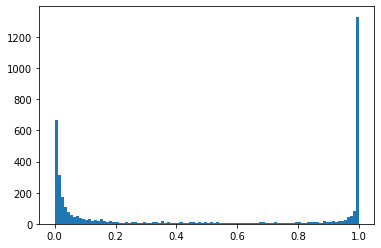

In [ ]:
diffs = []

for qid, answer in results[1].items():
    diffs.append(answer[0]['probability'] - answer[1]['probability'])

res = plt.hist(diffs, bins=100)

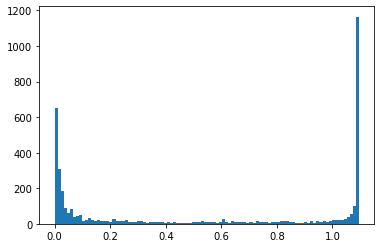

In [ ]:
diffs = []

for qid, answer in combined_results.items():
    diffs.append(answer[0]['probability'] - answer[1]['probability'])

res = plt.hist(diffs, bins=100)

In [ ]:
max(diffs)

1.09576704070481

## Test Set 1

In [ ]:
test_data = {
  "questions": [
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34687634"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "INTERPRETATION: 12 months of treatment with losartan was well tolerated but was not effective in reducing the rate of brain atrophy in individuals with clinically diagnosed mild-to-moderate Alzheimer\u0027s disease.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34687634",
          "offsetInBeginSection": 2574,
          "offsetInEndSection": 2784
        }
      ],
      "id": "6402c910201352f04a00000c",
      "type": "yesno",
      "body": "Can losartan reduce brain atrophy in Alzheimer\u0027s disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35633976",
        "http://www.ncbi.nlm.nih.gov/pubmed/35321760",
        "http://www.ncbi.nlm.nih.gov/pubmed/35196337",
        "http://www.ncbi.nlm.nih.gov/pubmed/35493941"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CHecklist for critical Appraisal and data extraction for systematic Reviews of prediction Modelling Studies (CHARMS).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35633976",
          "offsetInBeginSection": 452,
          "offsetInEndSection": 569
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We will extract data based on the Checklist for Critical Appraisal and Data Extraction for Systematic Reviews of Prediction Modeling Studies (CHARMS), ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35321760",
          "offsetInBeginSection": 1208,
          "offsetInEndSection": 1359
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Checklist for Critical Appraisal and Data Extraction for Systematic Reviews of Prediction Modeling Studies (CHARMS-PF).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35196337",
          "offsetInBeginSection": 688,
          "offsetInEndSection": 807
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Critical Appraisal and Data Extraction for Systematic Reviews of Prediction Modeling Studies (CHARMS)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35493941",
          "offsetInBeginSection": 892,
          "offsetInEndSection": 993
        }
      ],
      "id": "640f857d201352f04a00002b",
      "type": "factoid",
      "body": "What is CHARMS with respect to medical review of predictive modeling?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36375644"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Our work suggests that an intricate interplay of programs controlling gene expression levels and AS is fundamental to organ development, especially for the brain and heart.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33941934",
          "offsetInBeginSection": 745,
          "offsetInEndSection": 917
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Bioinformatical analysis pointed to the tissue-specific splicing factors Srrm4 and Nova1 as likely upstream regulators of the observed splicing changes in the PLN-R14del cardiomyocytes. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36375644",
          "offsetInBeginSection": 1266,
          "offsetInEndSection": 1452
        }
      ],
      "id": "6410eb95201352f04a00002e",
      "type": "list",
      "body": "Which splicing factors have been associated with alternative splicing in PLN R14del hearts?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/31381525",
        "http://www.ncbi.nlm.nih.gov/pubmed/26284620",
        "http://www.ncbi.nlm.nih.gov/pubmed/21402533",
        "http://www.ncbi.nlm.nih.gov/pubmed/23620649"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " 64% deletions, 18% duplications and 18% point mutations. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31381525",
          "offsetInBeginSection": 620,
          "offsetInEndSection": 678
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Of these, 406 (70.5%) were exonic deletions, 64 (11.1%) were exonic duplications, and one was a deletion/duplication complex rearrangement (0.2%). Small mutations were identified in 105 cases (18.2%), most being nonsense/frameshift types (75.2%). Mutations in splice sites, however, were relatively frequent (20%). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26284620",
          "offsetInBeginSection": 926,
          "offsetInEndSection": 1241
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "gene deletion rate was 54.3% (391/720), and gene duplication rate was 10.6% (76/720)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/21402533",
          "offsetInBeginSection": 440,
          "offsetInEndSection": 524
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The rate of deletion mutant occurred in Exon 45-54 was 71.9% (281/391) in all gene deletion patients; meanwhile, the rate of gene duplication occurred in Exon 1-40 was 82.9% (63/76) in all gene duplication ones.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/21402533",
          "offsetInBeginSection": 526,
          "offsetInEndSection": 737
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In all the patients with gene deletion and duplication, the rate of DMD and IMD was 90.6% (423/467), and BMD, 9.4% (44/467).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/21402533",
          "offsetInBeginSection": 738,
          "offsetInEndSection": 862
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The Duchenne Muscular dystrophy (DMD) is the most frequent muscle disorder in childhood caused by mutations in the Xlinked dystrophin gene (about 65% deletions, about 7% duplications, about 26% point mutations and about 2% unknown mutations). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23620649",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 243
        }
      ],
      "id": "64162fb0690f196b5100001a",
      "type": "list",
      "body": "What are the most common mutation types in Duchenne muscular Dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35939578",
        "http://www.ncbi.nlm.nih.gov/pubmed/36069871"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Trial of Anti-BDCA2 Antibody Litifilimab for Cutaneous Lupus Erythematosus.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35939578",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 75
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Whether treatment with litifilimab, a humanized monoclonal antibody against BDCA2, would be efficacious in reducing disease activity in patients with cutaneous lupus erythematosus has not been extensively studied.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35939578",
          "offsetInBeginSection": 193,
          "offsetInEndSection": 406
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Trial of Anti-BDCA2 Antibody Litifilimab for Systemic Lupus Erythematosus.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36069871",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 74
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " The safety and efficacy of subcutaneous litifilimab, a humanized monoclonal antibody that binds to BDCA2, in patients with SLE have not been extensively studied.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36069871",
          "offsetInBeginSection": 258,
          "offsetInEndSection": 420
        }
      ],
      "id": "63eef3ebf36125a42600000a",
      "type": "factoid",
      "body": "What is the target of Litifilimab?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35610482",
        "http://www.ncbi.nlm.nih.gov/pubmed/35426141",
        "http://www.ncbi.nlm.nih.gov/pubmed/35438215"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": ". The area under the receiver operator characteristics curve (AUROC)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35610482",
          "offsetInBeginSection": 847,
          "offsetInEndSection": 915
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "area under receiver operator curve [AUROC] ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35426141",
          "offsetInBeginSection": 1513,
          "offsetInEndSection": 1556
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The model performance was evaluated using the area under the receiver operating characteristic curve (AUROC)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35438215",
          "offsetInBeginSection": 819,
          "offsetInEndSection": 927
        }
      ],
      "id": "64136fbf201352f04a00003d",
      "type": "factoid",
      "body": "What is AUROC in context of predictive modeling?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34348142"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "PRP-40 regulation of neuronal microexons is therefore a widely conserved phenomenon.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34348142",
          "offsetInBeginSection": 1011,
          "offsetInEndSection": 1095
        }
      ],
      "id": "63fa13da201352f04a000001",
      "type": "yesno",
      "body": "Is PRP-40 regulation of microexons a conserved phenomenon?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33861387"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Casimersen received its first approval on 25 February 2021, in the USA, for the treatment of DMD in patients who have a confirmed mutation of the DMD gene that is amenable to exon 45 skipping. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33861387",
          "offsetInBeginSection": 568,
          "offsetInEndSection": 761
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "he approval, granted under the US FDA Accelerated Approval Program, was based on an observed increase in dystrophin production in skeletal muscle in patients treated with casimersen",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33861387",
          "offsetInBeginSection": 762,
          "offsetInEndSection": 943
        }
      ],
      "id": "64178e15690f196b51000020",
      "type": "yesno",
      "body": "Is casimersen effective for the treatment of Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35651477",
        "http://www.ncbi.nlm.nih.gov/pubmed/35658024",
        "http://www.ncbi.nlm.nih.gov/pubmed/35593668"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Designing a Dual GLP-1R/GIPR Agonist from Tirzepatide: Comparing Residues Between Tirzepatide, GLP-1, and GIP.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35651477",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 110
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "he efficacy and safety of tirzepatide, a novel glucose-dependent insulinotropic polypeptide and glucagon-like peptide-1 receptor agonist, in people with obesity are not known.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35658024",
          "offsetInBeginSection": 102,
          "offsetInEndSection": 277
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Tirzepatide - a dual GIP/GLP-1 receptor agonist - a new antidiabetic drug with potential metabolic activity in the treatment of type 2 diabetes.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35593668",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 144
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The incretin hormones glucagon-like peptide 1 (GLP-1) and glucose-dependent insulinotropic polypeptide (GIP) are responsible for up to 65% of postprandial insulin secretion. Tirzepatide, developed by Eli Lilly, is a dual GIP/GLP-1 receptor agonist in the form of a synthetic linear peptide; its acylation technology allows it to bind to albumin, thus making it possible to dose the drug once a week. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35593668",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 400
        }
      ],
      "id": "63f02ceaf36125a426000015",
      "type": "summary",
      "body": "Which are the targets of Tirzepatide?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35779167",
        "http://www.ncbi.nlm.nih.gov/pubmed/32875343",
        "http://www.ncbi.nlm.nih.gov/pubmed/32568298"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "hydrotherapy,\" \"balneotherapy,\" \"spa therapy,\" \"spa treatment,\" \"creno-balneotherapy,\" \"water treatments,\" and \"aqua therapy,\" o",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35779167",
          "offsetInBeginSection": 187,
          "offsetInEndSection": 315
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Spa therapy is an integral part of the treatment of burn scars. The objective of this systematic review is to provide an overview of the spa therapy used in the treatment of burn scars and analyze its effects reported in clinical studies. We used the PRISMA checklist and queried 8 scientific databases from August 2019 to July 2020 for articles referenced with the specific key words: (burn) AND ((spa) OR (crenotherap*) OR (sulfur bath) OR (balneo*) OR (hydrotherap*) OR (mineral water) OR (thermal water) OR (spring water) OR (health resort medicine))",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32875343",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 554
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Soon after qualification, Fortescue Fox (1858-1940) began practice in a Scottish spa where he acquired a lifelong interest in chronic disorders, especially arthritis. He worked to improve the status of spa medicine, recasting it as medical hydrology",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32568298",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 249
        }
      ],
      "id": "640e2616201352f04a00002a",
      "type": "yesno",
      "body": "Is medical hydrology the same as Spa therapy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34564706"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "CYP1A2 polymorphisms modify the association of habitual coffee consumption with appetite, macronutrient intake, and body mass index: results from an observational cohort and a cross-over randomized study.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34564706",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 204
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "High coffee consumption was more prevalent in rapid compared to slow metabolizers (P \u003d 0.008 after adjustment for age, sex, and BMI) and was associated with lower appetite perception and lower BMI only in rapid metabolizers (P for interaction of rs762551 genotype*coffee consumption \u003d 0.002 and 0.048, respectively). This differential association of rs762551 genotype and coffee consumption with BMI was more evident in individuals at higher genetic risk of obesity (mean adjusted difference in BMI \u003d -5.82 kg/m2 for rapid versus slow/intermediate metabolizers who consumed more than 14 cups of coffee per week).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34564706",
          "offsetInBeginSection": 1340,
          "offsetInEndSection": 1952
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CYP1A2 rs762551 polymorphism modifies the association of habitual coffee consumption with BMI, in part by influencing appetite, energy intake and circulating levels of the orexigenic hormone asprosin. This association is more evident in subjects with high genetic predisposition to obesity. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34564706",
          "offsetInBeginSection": 1965,
          "offsetInEndSection": 2256
        }
      ],
      "id": "6410fa66201352f04a000034",
      "type": "summary",
      "body": "How does CYP1A2 relate to coffee consumption and apetite?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34797383",
        "http://www.ncbi.nlm.nih.gov/pubmed/34420980",
        "http://www.ncbi.nlm.nih.gov/pubmed/33523015"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Eteplirsen-treated patients experienced a statistically significant longer median time to LOA by 2.09 years (5.09 vs. 3.00 years, p \u003c 0.01) and significantly attenuated rates of pulmonary decline vs. natural history patients (FVC%p change: -3.3 vs. -6.0 percentage points annually, p \u003c 0.0001).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34420980",
          "offsetInBeginSection": 1347,
          "offsetInEndSection": 1641
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "At Years 3 and 4, eteplirsen-treated patients demonstrated markedly greater mean 6MWT than controls (difference in change from baseline of 132 m [95%CI (29, 235), p \u003d 0.015] at Year 3 and 159 m [95%CI (66, 253), p \u003d 0.002] at Year 4)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33523015",
          "offsetInBeginSection": 967,
          "offsetInEndSection": 1200
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "At Year 4, a significantly greater proportion of eteplirsen-treated patients were still ambulant versus controls (10/12 vs 3/11; p \u003d 0.020)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33523015",
          "offsetInBeginSection": 1202,
          "offsetInEndSection": 1341
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " In this retrospective matched control study, eteplirsen treatment resulted in attenuation of ambulatory decline over a 4-year observation period, supporting long-term benefit in patients with DMD.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33523015",
          "offsetInBeginSection": 1606,
          "offsetInEndSection": 1803
        }
      ],
      "id": "64178e73690f196b51000023",
      "type": "yesno",
      "body": "Is eteplirsen effective for the treatment of Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34308608",
        "http://www.ncbi.nlm.nih.gov/pubmed/33830214",
        "http://www.ncbi.nlm.nih.gov/pubmed/35656777"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: All three ARAT agents are efficacious options for the treatment of nmCRPC, whereas darolutamide appears to have the most favorable tolerability profile. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34308608",
          "offsetInBeginSection": 1482,
          "offsetInEndSection": 1648
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: For nonmetastatic castration-resistant prostate cancer (nmCRPC), 3 drugs under patent protection-apalutamide, enzalutamide, and darolutamide-were approved based on randomized, placebo-controlled trials; 1 drug with generic availability, abiraterone acetate, showed efficacy in a single-arm trial and is commonly prescribed.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33830214",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 335
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: For nmCRPC, darolutamide offered optimal efficacy and safety among approved drugs, and abiraterone acetate may offer comparable metastasis-free survival benefit with cost savings from generic availability. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33830214",
          "offsetInBeginSection": 1701,
          "offsetInEndSection": 1920
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Darolutamide and survival in metastatic, hormone-sensitive prostate cancer: a patient and caregiver perspective and plain language summary of the ARASENS trial.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35656777",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 160
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Darolutamide is an approved treatment for a different type of prostate cancer called non-metastatic, castration-resistant prostate cancer (also called nmCRPC).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35656777",
          "offsetInBeginSection": 687,
          "offsetInEndSection": 846
        }
      ],
      "id": "63f03939f36125a42600001b",
      "type": "summary",
      "body": "What is the use of darolutamide?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/17948213",
        "http://www.ncbi.nlm.nih.gov/pubmed/34698404",
        "http://www.ncbi.nlm.nih.gov/pubmed/36005471",
        "http://www.ncbi.nlm.nih.gov/pubmed/35130356"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " Selective SFN (without large fiber affection) manifests with pain, sensory disturbances, or autonomic dysfunction. T",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35130356",
          "offsetInBeginSection": 155,
          "offsetInEndSection": 272
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Neuropathic pain (NP) is a main feature of Fabry disease (FD) as consequence of small fiber neuropathy. Restless legs syndrome (RLS) in FD was not described, but it is an important feature in other small fiber neuropathies",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/17948213",
          "offsetInBeginSection": 14,
          "offsetInEndSection": 236
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "mall fiber neuropathy (SFN) can be associated with autoantibodies, including those of IgM class with specificity for the trisulfated heparan disaccharide (TS-HDS) antigen.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34698404",
          "offsetInBeginSection": 13,
          "offsetInEndSection": 184
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Up to 50% of small fiber neuropathy (SFN) cases are idiopathic, but novel antibodies to Trisulfated Heparin Disaccharide (TS-HDS) and fibroblast growth factor receptor 3 (FGFR-3) have been implicated in half of these cases",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36005471",
          "offsetInBeginSection": 12,
          "offsetInEndSection": 234
        }
      ],
      "id": "64136664201352f04a00003b",
      "type": "list",
      "body": "What are the main clinical features of small-fiber neuropathy (SFN)?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/28835513"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "On October 24, 2016, the U.S. Food and Drug Administration (FDA) approved pembrolizumab (Keytruda; Merck \u0026 Co., Inc., https://www.merck.com) for treatment of patients with metastatic non-small cell lung cancer (mNSCLC) whose tumors express programmed death-ligand 1 (PD-L1) as determined by an FDA-approved test, as follows: (a) first-line treatment of patients with mNSCLC whose tumors have high PD-L1 expression (tumor proportion score [TPS] ≥50%), with no epidermal growth factor receptor (EGFR) or anaplastic lymphoma kinase (ALK) genomic tumor aberrations, and (b) treatment of patients with mNSCLC whose tumors express PD-L1 (TPS ≥1%), with disease progression on or after platinum-containing chemotherapy. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/28835513",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 713
        }
      ],
      "id": "6415c53e690f196b51000012",
      "type": "factoid",
      "body": "When was Keytruda approved by the FDA for the treatment of metastatic non-small cell lung cancer?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34175043",
        "http://www.ncbi.nlm.nih.gov/pubmed/29351004",
        "http://www.ncbi.nlm.nih.gov/pubmed/31603849"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " In relation to clinical trials, in the last ten years, has experienced great advances in the field of therapeutic options, divided into two major therapeutic targets: 1) the area of gene therapies and 2) trying to reverse or block the pathophysiological processes of the disease, such as inflammation, fibrosis, muscle regeneration, etc. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31603849",
          "offsetInBeginSection": 706,
          "offsetInEndSection": 1045
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Several promising gene therapies are currently under investigation. These include gene replacement, exon skipping, suppression of stop codons.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29351004",
          "offsetInBeginSection": 646,
          "offsetInEndSection": 788
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "More recently, a promising gene editing tool referred to as CRISPR/Cas9 offers exciting perspectives for restoring dystrophin expression in patients with DMD.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29351004",
          "offsetInBeginSection": 789,
          "offsetInEndSection": 947
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Adeno-associated virus-vectorized gene therapies to restore dystrophin protein expression using gene replacement or antisense oligonucleotide-mediated pre-mRNA splicing modulation have emerged, making great strides in uncovering barriers to gene therapies for DMD and other genetic diseases",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34175043",
          "offsetInBeginSection": 271,
          "offsetInEndSection": 561
        }
      ],
      "id": "6417949d690f196b51000035",
      "type": "list",
      "body": "Which gene therapies are under investigation for Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35939579"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Germline Mutations in CIDEB and Protection against Liver Disease.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35939579",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 65
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We also found that variants in CIDEB, which encodes a structural protein found in hepatic lipid droplets, had a protective effect. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35939579",
          "offsetInBeginSection": 897,
          "offsetInEndSection": 1028
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: Rare germline mutations in CIDEB conferred substantial protection from liver disease.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35939579",
          "offsetInBeginSection": 2119,
          "offsetInEndSection": 2217
        }
      ],
      "id": "63f02a82f36125a426000013",
      "type": "yesno",
      "body": "Does CIDEB mutation protect from liver disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35628286",
        "http://www.ncbi.nlm.nih.gov/pubmed/34605036",
        "http://www.ncbi.nlm.nih.gov/pubmed/31603123",
        "http://www.ncbi.nlm.nih.gov/pubmed/12432243",
        "http://www.ncbi.nlm.nih.gov/pubmed/9766517"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Cdk9 is a member of the Cdc2-like family of kinases. Its cyclin partners are members of the family of cyclin T (T1, T2a and T2b) and cyclin K. The Cdk9/cyclin T complexes appear to be involved in regulating several physiological processes",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/12432243",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 238
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We previously cloned a cdc2-related kinase, cdk9/PITALRE, that is able to phosphorylate the retinoblastoma protein i",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/9766517",
          "offsetInBeginSection": 120,
          "offsetInEndSection": 236
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "hese results suggest that, among other roles, cdk9/PITALRE plays a role not unlike cdk5 in the differentiation of certain cell types.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/9766517",
          "offsetInBeginSection": 924,
          "offsetInEndSection": 1057
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " CDK9/Cyclin T1 kinase is a protein kinase, indirectly involved in the cell cycle progression in the form of transcription elongation",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31603123",
          "offsetInBeginSection": 10,
          "offsetInEndSection": 143
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Among various clinically validated kinases, the cyclin-dependent kinases (CDK) are one of the extensively studied drug targets for clinical developmen",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34605036",
          "offsetInBeginSection": 152,
          "offsetInEndSection": 302
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Cyclin-dependent kinases (CDKs) are a broad family of proteins involved in the cell cycle and transcriptional regulation. In this article, we explore the antitumoral activity of a novel proteolysis-targeting chimera (PROTAC) compound against CDK9",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35628286",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 246
        }
      ],
      "id": "64089b21201352f04a000021",
      "type": "summary",
      "body": "Can you summarize the function of CDK9?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36454480"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Thus, our data suggest that RBM24 is a critical regulator of CaMKIIδ to control the cardiac QT interval, highlighting the key role of splicing regulation in cardiac rhythm.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36454480",
          "offsetInBeginSection": 1178,
          "offsetInEndSection": 1350
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "RBM24 controls cardiac QT interval through CaMKIIδ splicing.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36454480",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 60
        }
      ],
      "id": "6410eead201352f04a000030",
      "type": "summary",
      "body": "How does RBM24 control QT interval?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35501714",
        "http://www.ncbi.nlm.nih.gov/pubmed/35618576",
        "http://www.ncbi.nlm.nih.gov/pubmed/35626905",
        "http://www.ncbi.nlm.nih.gov/pubmed/35862363",
        "http://www.ncbi.nlm.nih.gov/pubmed/35998119",
        "http://www.ncbi.nlm.nih.gov/pubmed/35385138"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The results showed a significant difference in the NSAA score between the deletion and nonsense groups at the age of 3 years (P \u003d 0.04).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35501714",
          "offsetInBeginSection": 1854,
          "offsetInEndSection": 1990
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The boys were evaluated with standardized assessments at the screening and baseline visits at 32 sites in 5 countries (US, UK, Canada, Italy, Germany). Assessments included timed rise from floor, timed 10 m walk/run, six-minute walk distance, North Star Ambulatory Assessment (NSAA) and forced vital capacity (FVC). Mean age at baseline was 5.9 years (range 4.1-8.1 years). Test-retest reliability was high for functional assessments, regardless of time lag between assessments (up to 90 days) and for the majority of age groups. Correlations were strong among the functional measures and timed tests, less so with FVC.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35618576",
          "offsetInBeginSection": 583,
          "offsetInEndSection": 1202
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The North Star Ambulatory Assessment (NSAA) is a validated 17-item functional rating scale and widely used to assess motor function in boys with Duchenne muscular dystrophy (DMD).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35626905",
          "offsetInBeginSection": 11,
          "offsetInEndSection": 190
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "he Duchenne Muscular Dystrophy Upper-limb Patient-reported Outcome Measure, North Star Ambulatory Assessment, and Myotonic Dystrophy Type 1 Activity and Participation Scale for Clinical Use are also recommended.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35862363",
          "offsetInBeginSection": 2214,
          "offsetInEndSection": 2425
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "A systematic review of patient-reported outcome measures was conducted on the MEDLINE, Embase, AMED, DiTA, and PsycINFO databases in August 2020. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35862363",
          "offsetInBeginSection": 173,
          "offsetInEndSection": 319
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "hese exploratory analyses reveal additional approaches to interpreting the NSAA data beyond just change in NSAA total score. These observations also highlight the importance of reporting items as \"not obtainable\" for a patient with a temporary/transient physical disability that impacts their ability to perform the NSAA test.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35998119",
          "offsetInBeginSection": 1319,
          "offsetInEndSection": 1645
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "To correlate the North Star Ambulatory Assessment (NSAA) and timed rise from floor (TRF) recorded at age of expected peak with age at loss of ambulation (LOA) in Duchenne muscular dystrophy (DMD).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35385138",
          "offsetInBeginSection": 5,
          "offsetInEndSection": 201
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Higher functional abilities at peak are associated with older age at LOA in DMD.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35385138",
          "offsetInBeginSection": 1339,
          "offsetInEndSection": 1419
        }
      ],
      "id": "64105502201352f04a00002d",
      "type": "yesno",
      "body": "Is North Star Ambulatory Assessment score a reliable clinical outcome for disease progression assessment in Duchenne Muscular Dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35301810",
        "http://www.ncbi.nlm.nih.gov/pubmed/35302767",
        "http://www.ncbi.nlm.nih.gov/pubmed/36182620"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "This study aimed to define the clinically relevant supratherapeutic dose of rilzabrutinib, an oral Bruton tyrosine kinase (BTK) inhibitor, and evaluate potential effects of therapeutic and supratherapeutic exposures on cardiac repolarization in healthy subjects.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35301810",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 262
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Discovery of Reversible Covalent Bruton\u0027s Tyrosine Kinase Inhibitors PRN473 and PRN1008 (Rilzabrutinib).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35302767",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 104
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Herein, we describe the design of covalent reversible BTK inhibitors and the discoveries of PRN473 (11) and rilzabrutinib (PRN1008, 12). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35302767",
          "offsetInBeginSection": 303,
          "offsetInEndSection": 440
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Ongoing trials include new B-cell/plasma-cell targeting agents such as the Bruton tyrosine kinase inhibitors ibrutinib and rilzabrutinib, and the anti-CD38 MoAbs daratumumab and its analogue isatuximab. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36182620",
          "offsetInBeginSection": 813,
          "offsetInEndSection": 1016
        }
      ],
      "id": "63f032caf36125a42600001a",
      "type": "summary",
      "body": "What is the mechanism of action of rilzabrutinib?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35562130",
        "http://www.ncbi.nlm.nih.gov/pubmed/35587830"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " Adult-type diffuse gliomas are genetically defined and include astrocytoma, isocitrate dehydrogenase (IDH)-mutant, oligodendroglioma, IDH-mutant and 1p/19q codeleted, and glioblastoma, IDH-wildtype",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35562130",
          "offsetInBeginSection": 237,
          "offsetInEndSection": 435
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " According to the 2021 World Health Organization classification, the three risk types included (1) low-risk, expecting oligodendroglioma, isocitrate dehydrogenase (IDH)-mutant, and 1p/19q-codeleted; (2) intermediate-risk, expecting astrocytoma, IDH-mutant; and (3) high-risk, expecting glioblastoma, IDH-wildtype.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35587830",
          "offsetInBeginSection": 456,
          "offsetInEndSection": 769
        }
      ],
      "id": "641368ee201352f04a00003c",
      "type": "list",
      "body": "What are the  types/categories of adult diffuse gliomas."
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33833444"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Engineered T cells have achieved success in the treatment of blood cancers, with four chimeric antigen receptor (CAR)-T cell therapies now approved for the treatment of B cell malignancies based on their unprecedented efficacy in clinical trials. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33833444",
          "offsetInBeginSection": 345,
          "offsetInEndSection": 592
        }
      ],
      "id": "6415ca99690f196b51000019",
      "type": "yesno",
      "body": "Have chimeric antigen receptor (CAR)-T cell therapies been approved for the treatment of B cell malignancies?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34788571",
        "http://www.ncbi.nlm.nih.gov/pubmed/36401026",
        "http://www.ncbi.nlm.nih.gov/pubmed/32026421",
        "http://www.ncbi.nlm.nih.gov/pubmed/33025945"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Golodirsen is a provisionally approved PMO-based drug for approx. 8% of all DMD patients amenable to exon 53 skipping. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33025945",
          "offsetInBeginSection": 783,
          "offsetInEndSection": 902
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "This article summarizes the milestones in the development of golodirsen leading to this first approval for DMD.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32026421",
          "offsetInBeginSection": 599,
          "offsetInEndSection": 710
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "n December 2019, intravenous golodirsen received its first global approval in the USA for the treatment of DMD in patients with a confirmed mutation of the DMD gene that is amenable to exon 53 skipping, based on positive results from a phase I/II clinical trial",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32026421",
          "offsetInBeginSection": 252,
          "offsetInEndSection": 513
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "To date, four PMOs, including eteplirsen, casimersen, viltolarsen, and golodirsen, have been conditionally approved by the FDA for the treatment of DMD.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36401026",
          "offsetInBeginSection": 334,
          "offsetInEndSection": 486
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Golodirsen increased dystrophin protein (16.0-fold; P \u003c 0.001) and exon skipping (28.9-fold; P \u003c 0.001).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34788571",
          "offsetInBeginSection": 965,
          "offsetInEndSection": 1069
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "This study provides evidence for golodirsen biologic activity and long-term safety in a declining DMD population and suggests functional benefit versus external controls. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34788571",
          "offsetInBeginSection": 1381,
          "offsetInEndSection": 1552
        }
      ],
      "id": "64178e4b690f196b51000022",
      "type": "yesno",
      "body": "Is golodirsen effective for the treatment of Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35330989",
        "http://www.ncbi.nlm.nih.gov/pubmed/35334197"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Thus far, it has been approved for the treatment of rheumatoid arthritis (RA); however, an increasing number of studies have suggested that baricitinib can be used to treat dermatological diseases, such as atopic dermatitis (AD), psoriasis, vitiligo, and alopecia areata. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35330989",
          "offsetInBeginSection": 345,
          "offsetInEndSection": 617
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We reviewed the application, efficacy, side effects, precautions, limitations and prospect of baricitinib in atopic dermatitis, psoriasis, vitiligo and alopecia areata (AA) in recent 5 years including clinical trials and case reports. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35330989",
          "offsetInBeginSection": 744,
          "offsetInEndSection": 979
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Two Phase 3 Trials of Baricitinib for Alopecia Areata.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35334197",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 54
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: In two phase 3 trials involving patients with severe alopecia areata, oral baricitinib was superior to placebo with respect to hair regrowth at 36 weeks. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35334197",
          "offsetInBeginSection": 1870,
          "offsetInEndSection": 2037
        }
      ],
      "id": "63f043e4f36125a426000023",
      "type": "yesno",
      "body": "Is Baricitinib effective for Alopecia Areata?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35774427",
        "http://www.ncbi.nlm.nih.gov/pubmed/21877597",
        "http://www.ncbi.nlm.nih.gov/pubmed/2010480"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "This study was to explore the clinical efficacy and safety of darbepoetin alfa injection replacing epoetin alfa injection (recombinant human erythropoietin injection, rHuEPO) for the treatment of anemia associated with chronic kidney failure",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35774427",
          "offsetInBeginSection": 12,
          "offsetInEndSection": 253
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Anaemia is a common manifestation ofa chronic kidney failure. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/21877597",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 62
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The hormone deficiency that underlies anemia in chronic kidney failure can now be corrected",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/2010480",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 91
        }
      ],
      "id": "64137616201352f04a000041",
      "type": "yesno",
      "body": "Anemia is not associated with chronic kidney failure"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/26785833"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We estimated reduced time and costs by online counseling with about 8% and 10-12%, respectively. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26785833",
          "offsetInBeginSection": 1548,
          "offsetInEndSection": 1645
        }
      ],
      "id": "6415bc8d690f196b5100000f",
      "type": "factoid",
      "body": "What is the estimated reduction in time when using online genetic counseling?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35381069",
        "http://www.ncbi.nlm.nih.gov/pubmed/35723111"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Both daily prednisone and daily deflazacort were more effective than intermittent prednisone for the primary outcome (P \u003c .001 for daily prednisone vs intermittent prednisone using a global test; P \u003d .017 for daily deflazacort vs intermittent prednisone using a global test)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35381069",
          "offsetInBeginSection": 1505,
          "offsetInEndSection": 1779
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Among patients with Duchenne muscular dystrophy, treatment with daily prednisone or daily deflazacort, compared with intermittent prednisone alternating 10 days on and 10 days off, resulted in significant improvement over 3 years in a composite outcome comprising measures of motor function, pulmonary function, and satisfaction with treatment",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35381069",
          "offsetInBeginSection": 2790,
          "offsetInEndSection": 3133
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Deflazacort and prednisone/prednisolone are the current standard of care for patients with Duchenne muscular dystrophy (DMD) based on evidence that they improve muscle strength, improve timed motor function, delay loss of ambulation, improve pulmonary function, reduce the need for scoliosis surgery, delay onset of cardiomyopathy, and increase survival.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35723111",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 354
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Evidence from randomized clinical trials, prospective studies, meta-analyses, and post-hoc analyses suggests that patients receiving deflazacort experience similar or slower rates of functional decline compared with those receiving prednisone/prednisolone. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35723111",
          "offsetInBeginSection": 885,
          "offsetInEndSection": 1142
        }
      ],
      "id": "64163660690f196b5100001d",
      "type": "yesno",
      "body": "Is deflazacort more efficient than prednisone/prednisolone for the treatment of Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35928819",
        "http://www.ncbi.nlm.nih.gov/pubmed/35947358",
        "http://www.ncbi.nlm.nih.gov/pubmed/35803286",
        "http://www.ncbi.nlm.nih.gov/pubmed/35182296"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "They combine two different monospecific antigen-binding regions that target CD20 on B cells and engage T cells via CD3 in a 1:1 or 2:1 CD20:CD3 antigen binding fragment (Fab) format. The results of different phase 1 trials with BsAbs, including mosunetuzumab, glofitamab, epcoritamab and odeonextamab, have been recently published.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35928819",
          "offsetInBeginSection": 663,
          "offsetInEndSection": 994
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Mosunetuzumab (Lunsumio®), an anti-CD20/CD3 T-cell engaging bispecific antibody, is being developed by Roche for the treatment of relapsed or refractory follicular lymphoma. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35947358",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 174
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Mosunetuzumab is a CD20 × CD3 T-cell-engaging bispecific monoclonal antibody that redirects T cells to eliminate malignant B cells. I",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35803286",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 145
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "However, several CD20 × CD3 BsAbs including odronextamab, mosunetuzumab, glofitamab, and epcoritamab emerged recently. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35182296",
          "offsetInBeginSection": 655,
          "offsetInEndSection": 774
        }
      ],
      "id": "6402bc2d201352f04a000005",
      "type": "list",
      "body": "What are the targets of Mosunetuzumab?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/20678798",
        "http://www.ncbi.nlm.nih.gov/pubmed/23855441",
        "http://www.ncbi.nlm.nih.gov/pubmed/17128671",
        "http://www.ncbi.nlm.nih.gov/pubmed/19082920"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Mast cells are important effector cells in allergic inflammatory reactions. The aggregation of the high-affinity IgE receptor (FcepsilonRI) on the surface of mast cells initiates a complex cascade of signaling events that ultimately leads to the release of various mediators involved in allergic inflammation and anaphylactic reactions",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/19082920",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 335
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "During the IgE-mediated anaphylactic reaction mast cells release proteases such as tryptase, histamine and vasoactive mediators",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/17128671",
          "offsetInBeginSection": 101,
          "offsetInEndSection": 228
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Histamine and other deleterious inflammatory mediators promote vascular permeability and smooth muscle contraction; they are readily released from sensitized mast cells and basophils challenged with antigen. Anaphylaxis may be triggered by a variety of antigens including insect and reptile venom, a variety of drugs, vaccines, and food",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23855441",
          "offsetInBeginSection": 485,
          "offsetInEndSection": 821
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Earlier mast cells were only known for their important role in the type 1 allergic reactions (i.e. anaphylaxis or some contact hypersensitivity reactions) ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/20678798",
          "offsetInBeginSection": 209,
          "offsetInEndSection": 364
        }
      ],
      "id": "64144200201352f04a000043",
      "type": "yesno",
      "body": "Is anaphylaxis a results of mast cell activation?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/28835513"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Approval was based on two randomized, open-label, active-controlled trials demonstrating statistically significant improvements in progression-free survival (PFS) and overall survival (OS) for patients randomized to pembrolizumab compared with chemotherapy. In KEYNOTE-024, patients with previously untreated mNSCLC who received pembrolizumab (200 mg intravenously [IV] every 3 weeks) had a statistically significant improvement in OS (hazard ratio [HR] 0.60; 95% confidence interval [CI]: 0.41-0.89; p \u003d .005), and significant improvement in PFS (HR 0.50; 95% CI: 0.37-0.68; p \u003c .001). In KEYNOTE-010, patients with disease progression on or after platinum-containing chemotherapy received pembrolizumab IV 2 mg/kg, 10 mg/kg, or docetaxel 75 mg/m2 every 3 weeks. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/28835513",
          "offsetInBeginSection": 876,
          "offsetInEndSection": 1640
        }
      ],
      "id": "6415c6b6690f196b51000015",
      "type": "list",
      "body": "On which two clinical trials was the approval of Keytruda based?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36401022"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Viltolarsen is a phosphorodiamidate morpholino antisense oligonucleotide (PMO) designed to skip exon 53 of the DMD gene for the treatment of Duchenne muscular dystrophy (DMD)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36401022",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 174
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Viltolarsen restores the reading frame of the DMD gene by skipping  exon 53 and produces a truncated but functional form of dystrophin. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36401022",
          "offsetInBeginSection": 694,
          "offsetInEndSection": 830
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "After showing hopeful results in pre-clinical trials and several clinical trials across North America and Japan, it received US Food and Drug Administration (FDA) approval for DMD in 2020.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36401022",
          "offsetInBeginSection": 505,
          "offsetInEndSection": 693
        }
      ],
      "id": "64178e34690f196b51000021",
      "type": "yesno",
      "body": "Is viltolarsen effective for the treatment of Duchenne muscular dystrophy?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32116320",
        "http://www.ncbi.nlm.nih.gov/pubmed/32317620",
        "http://www.ncbi.nlm.nih.gov/pubmed/33655184",
        "http://www.ncbi.nlm.nih.gov/pubmed/33083170",
        "http://www.ncbi.nlm.nih.gov/pubmed/32821627",
        "http://www.ncbi.nlm.nih.gov/pubmed/32399444"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: The superior mesenteric artery (SMA) syndrome, also known as Wilkie\u0027s syndrome, is one of the rarest causes of small bowel obstruction.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32116320",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 147
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND Nutcracker syndrome and Wilkie\u0027s syndrome are rare vascular diseases due to the abnormal course of the superior mesenteric artery originating from the abdominal aorta with reduced angle (\u003c22°) and consequent compression of the left renal vein (nutcracker) and duodenum (Wilkie). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32317620",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 290
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "INTRODUCTION: Wilkie\u0027s Syndrome, also known as Superior Mesenteric Artery Syndrome (SMAS), is a rare cause of bowel obstruction that can contribute to vague abdominal symptoms on clinical presentation.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33655184",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 201
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Superior mesenteric artery syndrome, or Wilkie\u0027s syndrome, is an unexpected cause of upper gastrointestinal tract obstruction. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33083170",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 127
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Introduction Superior mesenteric artery (SMA) or Wilkie\u0027s syndrome is a rare condition arising due to compression of the third part of the duodenum between the abdominal aorta and the superior mesenteric artery. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32821627",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 212
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Superior mesenteric artery syndrome (SMA syndrome) or Wilkie\u0027s syndrome is a rare etiology of duodenal obstruction due to compression of the third portion of the duodenum between the superior mesenteric artery and the aorta. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32399444",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 225
        }
      ],
      "id": "640410d1201352f04a000012",
      "type": "summary",
      "body": "What is Wilkie\u0027s syndrome?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35680848",
        "http://www.ncbi.nlm.nih.gov/pubmed/35671157",
        "http://www.ncbi.nlm.nih.gov/pubmed/35412837"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "PROteolysis TArgeting Chimeras (PROTACs) technology is a new protein-degradation strategy that has emerged in recent years.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35680848",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 123
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Proteolysis-targeting chimeras (PROTACs) are heterobifunctional molecules consisting of one ligand that binds to a protein of interest (POI) and another that can recruit an E3 ubiquitin ligase. The chemically-induced proximity between the POI and E3 ligase results in ubiquitination and subsequent degradation of the POI by the ubiquitin-proteasome system (UPS).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35671157",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 362
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Proteolysis targeting chimeras (PROTACs) are molecules that induce protein degradation via formation of ternary complexes between an E3 ubiquitin ligase and a target protein. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35412837",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 175
        }
      ],
      "id": "641461bb201352f04a000046",
      "type": "summary",
      "body": "What is a PROTAC?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32770212"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "The \"Virtual Digital Twins\" Concept in Precision Nutrition",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32770212",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 58
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We herein discuss how genetic information combined with longitudinal metabolomic, immune, behavioral, and gut microbial parameters, and bioclinical variables could define a digital replica of oneself, a \"virtual digital twin,\" which could serve to guide nutrition in a personalized manner.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32770212",
          "offsetInBeginSection": 559,
          "offsetInEndSection": 848
        }
      ],
      "id": "6410f839201352f04a000032",
      "type": "yesno",
      "body": "Can the concept of digital twins be applied in Precision Nutrition?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35661166",
        "http://www.ncbi.nlm.nih.gov/pubmed/35749004",
        "http://www.ncbi.nlm.nih.gov/pubmed/36006441",
        "http://www.ncbi.nlm.nih.gov/pubmed/36352205"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Teclistamab is a T-cell-redirecting bispecific antibody that targets both CD3 expressed on the surface of T cells and B-cell maturation antigen expressed on the surface of myeloma cells.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35661166",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 198
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Teclistamab (JNJ-64007957), a B-cell maturation antigen × CD3 bispecific antibody, displayed potent T-cell-mediated cytotoxicity of multiple myeloma cells in preclinical studies.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35749004",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 190
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The bispecific antibodies teclistamab (BCMA×CD3) and talquetamab (G protein-coupled receptor family C group 5 member D [GPRC5D]×CD3) are in clinical development as therapies for MM. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36006441",
          "offsetInBeginSection": 224,
          "offsetInEndSection": 406
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Teclistamab (TECVAYLI®), a bispecific antibody that targets CD3 and B cell maturation antigen (BCMA), is being developed by Janssen Research and Development for the treatment of relapsed or refractory multiple myeloma. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36352205",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 219
        }
      ],
      "id": "63eef6edf36125a42600000d",
      "type": "summary",
      "body": "What is the mechanism of action of Teclistamab?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34866042",
        "http://www.ncbi.nlm.nih.gov/pubmed/26291593",
        "http://www.ncbi.nlm.nih.gov/pubmed/19092641",
        "http://www.ncbi.nlm.nih.gov/pubmed/10770681"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The term cholestasis refers to bile acid retention, whether within the hepatocyte or in the bile ducts of any caliber. Biochemically, it is defined by a level of alkaline phosphatase that is 1.67-times higher than the upper limit of normal. Cholestatic diseases can be associated with an inflammatory process of the liver that destroys hepatocytes (hepatitis), withjaundice (yellowing of the skin and mucus membranes, associated with elevated serum bilirubin levels), or with both,",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34866042",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 481
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Workup revealed elevated liver transaminases, alkaline phosphatase, and conjugated bilirubin",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26291593",
          "offsetInBeginSection": 376,
          "offsetInEndSection": 468
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "he symptoms started about 1 week ago. Initial laboratory tests showed abnormal liver enzymes with elevated conjugated bilirubin and alkaline phosphatase suggestive of cholestatic jaundice. A",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/19092641",
          "offsetInBeginSection": 423,
          "offsetInEndSection": 613
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The outcome was evaluated by monitoring clinical and biochemical markers of cholestasis, including alanine aminotransferase, aspartate aminotransferase, alkaline phosphatase, gamma-glutamyl transpeptidase, cholesterol, total serum tasting bile acids and total and conjugated bilirubin ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/10770681",
          "offsetInBeginSection": 611,
          "offsetInEndSection": 896
        }
      ],
      "id": "640c8309201352f04a000024",
      "type": "list",
      "body": "The diagnosis of cholestasis is based on the elevations seen in what liver function tests?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/28835513"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "On October 24, 2016, the U.S. Food and Drug Administration (FDA) approved pembrolizumab (Keytruda; Merck \u0026 Co., Inc., https://www.merck.com) for treatment of patients with metastatic non-small cell lung cancer (mNSCLC) whose tumors express programmed death-ligand 1 (PD-L1) as determined by an FDA-approved test, as follows: (a) first-line treatment of patients with mNSCLC whose tumors have high PD-L1 expression (tumor proportion score [TPS] ≥50%), with no epidermal growth factor receptor (EGFR) or anaplastic lymphoma kinase (ALK) genomic tumor aberrations, and (b) treatment of patients with mNSCLC whose tumors express PD-L1 (TPS ≥1%), with disease progression on or after platinum-containing chemotherapy.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/28835513",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 712
        }
      ],
      "id": "6415c599690f196b51000013",
      "type": "factoid",
      "body": "Which company produces Keytruda?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34146512"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "INTERPRETATION: Pioglitazone did not delay the onset of mild cognitive impairment.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34146512",
          "offsetInBeginSection": 3711,
          "offsetInEndSection": 3793
        }
      ],
      "id": "64040edf201352f04a000011",
      "type": "yesno",
      "body": "Based on clinical trial data, can pioglitazone delay cognitive impairment for people at risk for Alzheimer\u0027s disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36252444",
        "http://www.ncbi.nlm.nih.gov/pubmed/35045330",
        "http://www.ncbi.nlm.nih.gov/pubmed/34316334",
        "http://www.ncbi.nlm.nih.gov/pubmed/31202702",
        "http://www.ncbi.nlm.nih.gov/pubmed/31187860"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Cereblon is a well-known target of thalidomide and its derivatives.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36252444",
          "offsetInBeginSection": 128,
          "offsetInEndSection": 195
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We have identified novel CRBN inhibitors, namely DHFO and its analogs, with structural features that are slightly different from thalidomide but stronger cereblon-binding affinity. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36252444",
          "offsetInBeginSection": 399,
          "offsetInEndSection": 580
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " It additionally modulates the anti-myeloma effect of the immunomodulatory drugs (IMiDs) thalidomide, lenalidomide, and pomalidomide. IMiDs bind to CRBN and recruit neo-substrates for their ubiquitination and proteasome-mediated degradation",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35045330",
          "offsetInBeginSection": 98,
          "offsetInEndSection": 338
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": ". Cereblon (CRBN)-targeting immunomodulatory agents (IMiDs®) lenalidomide (LEN) and pomalidomide (POM) play a central role in combination regimens due to their pleiotropic antitumor/immunomodulatory mechanisms that synergize with many anti-myeloma approved or developmental agents.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34316334",
          "offsetInBeginSection": 162,
          "offsetInEndSection": 443
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Thalidomide, well known for its potent teratogenicity, has been re-evaluated as a clinically effective drug for the treatment of multiple myeloma. Although the direct target of thalidomide had been unclear until recently, we identified cereblon (CRBN) as a primary direct target of this drug b",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31202702",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 293
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The molecular mechanism of action of IMiDs remained unclear for a long time until 2010 when the protein cereblon (CRBN) was identified as a primary direct target. IMiDs binds to CRBN and alters the substrate specificity of the CRBN E3 ubiquitin ligase complex, ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31187860",
          "offsetInBeginSection": 815,
          "offsetInEndSection": 1076
        }
      ],
      "id": "6414638c201352f04a000047",
      "type": "factoid",
      "body": "Cereblon (CRBN)  has been identified as the target for what type of drug?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33207694"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "SRRM4 Expands the Repertoire of Circular RNAs by Regulating Microexon Inclusion.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33207694",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 80
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Overexpressing SRRM4, known for regulating ME inclusion in mRNAs critical for neural differentiation, in human HEK293 cells resulted in the biogenesis of over 2000 novel ME-circRNAs, including ME-circEIF4G3, and changes in the abundance of many canonical circRNAs, including circSETDB2 and circLBRA. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33207694",
          "offsetInBeginSection": 1272,
          "offsetInEndSection": 1572
        }
      ],
      "id": "63f9cdb033942b094c000012",
      "type": "yesno",
      "body": "Does silencing of SRRM4 promote microexon inclusion?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35993765",
        "http://www.ncbi.nlm.nih.gov/pubmed/35914259",
        "http://www.ncbi.nlm.nih.gov/pubmed/35904210"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "AZD7442, a combination of two long-acting monoclonal antibodies (tixagevimab [AZD8895] and cilgavimab [AZD1061]), has been authorized for the prevention and treatment of coronavirus disease 2019 (COVID-19). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35993765",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 207
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Intramuscular AZD7442 (tixagevimab-cilgavimab) for prevention of Covid-19. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35914259",
          "offsetInBeginSection": 59,
          "offsetInEndSection": 134
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Association Between AZD7442 (Tixagevimab-Cilgavimab) Administration and Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) Infection, Hospitalization, and Mortality.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35904210",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 175
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Intramuscular AZD7442 (Tixagevimab-Cilgavimab, (Evusheld)) has been found effective among immunocompromised individuals (ICI) in reducing Sars-Cov-2 infection and severe disease in ICIs. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35904210",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 199
        }
      ],
      "id": "63f03a20f36125a42600001c",
      "type": "list",
      "body": "Which drugs are included in the AZD7442?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32984529",
        "http://www.ncbi.nlm.nih.gov/pubmed/26822752",
        "http://www.ncbi.nlm.nih.gov/pubmed/29222273",
        "http://www.ncbi.nlm.nih.gov/pubmed/25682878"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "2 different programmed cell death protein 1 (PD-1) inhibitors, Nivolumab and Pembrolizumab.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32984529",
          "offsetInBeginSection": 233,
          "offsetInEndSection": 324
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The first monoclonal antibodies against the immune checkpoint programmed death 1 (PD-1) receptor, nivolumab and pembrolizumab, are now approved for clinical use",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26822752",
          "offsetInBeginSection": 146,
          "offsetInEndSection": 306
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "e programmed cell death protein 1 (PD-1) inhibitors, nivolumab and pembrolizumab, have quickly been incorporated into clinical trials for first- and second-line therapy of Hodgkin lymphoma.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29222273",
          "offsetInBeginSection": 100,
          "offsetInEndSection": 289
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The first programmed death 1 (PD-1) inhibitor, pembrolizumab, was recently approved by the United States Food and Drug Administration for the treatment of melanoma; nivolumab was previously approved in Japan. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/25682878",
          "offsetInBeginSection": 361,
          "offsetInEndSection": 570
        }
      ],
      "id": "640ddd9d201352f04a000028",
      "type": "list",
      "body": "What were the first 2 PD-1 inhibitors approved by the FDA in 2014?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33808008"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Dermatillomania or skin picking disorder (SPD) is a chronic, recurrent, and treatment resistant neuropsychiatric disorder with an underestimated prevalence that has a concerning negative impact on an individual\u0027s health and quality of life. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33808008",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 241
        }
      ],
      "id": "6414c4cf690f196b51000006",
      "type": "factoid",
      "body": "What is the difference between dermatillomania and skin picking disorder?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32863353",
        "http://www.ncbi.nlm.nih.gov/pubmed/36016429",
        "http://www.ncbi.nlm.nih.gov/pubmed/35507925"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Non-pathogenic Rickettsia species LON strains closely related to an agent of Japanese spotted fever (JSF), R. japonica, were isolated in Japan from Haemaphysalis longicornis ticks in 2001. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32863353",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 189
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Severe fever with thrombocytopenia syndrome (SFTS) and Japanese spotted fever (JSF; a spotted fever group rickettsiosis) are tick-borne zoonoses that are becoming a significant public health threat in Japan and East Asia.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36016429",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 221
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Rickettsia japonica is a member of SFG rickettsiae causing Japanese spotted fever (JSF) and can transmit to humans via infected ticks. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35507925",
          "offsetInBeginSection": 153,
          "offsetInEndSection": 288
        }
      ],
      "id": "63eefa3bf36125a426000012",
      "type": "factoid",
      "body": "What causes Japanese Spotted Fever?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35668012",
        "http://www.ncbi.nlm.nih.gov/pubmed/30851544",
        "http://www.ncbi.nlm.nih.gov/pubmed/31436392"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "To compare the real-world safety profile of programmed cell death-1 (PD-1) and programmed cell death ligand-1 (PD-L1) inhibitors between younger and older patients",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35668012",
          "offsetInBeginSection": 14,
          "offsetInEndSection": 177
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Programmed Cell Death Receptor (PD-1) and its Ligand (PD-L1) pathway inhibitor therapy has been explored in the field of oncology treatment mainly for solid tumors.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/30851544",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 164
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " Inhibitors of programmed cell death-1 (PD-1) and its ligand (PD-L1) have been increasingly used in head and neck cancer therapy and reported to improve the outcomes with an acceptable safety profile.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31436392",
          "offsetInBeginSection": 11,
          "offsetInEndSection": 211
        }
      ],
      "id": "640dde93201352f04a000029",
      "type": "summary",
      "body": "What is the difference between PD-1 and PD-L1?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32770212"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We herein discuss how genetic information combined with longitudinal metabolomic, immune, behavioral, and gut microbial parameters, and bioclinical variables could define a digital replica of oneself, a \"virtual digital twin,\" which could serve to guide nutrition in a personalized manner. Such a model may revolutionize the management of obesity and its comorbidities, and provide a pillar for healthy aging.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32770212",
          "offsetInBeginSection": 559,
          "offsetInEndSection": 968
        }
      ],
      "id": "6410f8b2201352f04a000033",
      "type": "summary",
      "body": "What would be the benefits of using a virtual digital twin in nutrition?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34536404",
        "http://www.ncbi.nlm.nih.gov/pubmed/31315908"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "INTERPRETATION: Levosimendan was not superior to placebo in maintaining respiratory function in a broad population with amyotrophic lateral sclerosis. Although levosimendan was generally well tolerated, increased heart rate and headache occurred more frequently with levosimendan than with placebo.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34536404",
          "offsetInBeginSection": 2720,
          "offsetInEndSection": 3018
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: Levosimendan did not achieve the primary endpoint of improving sitting SVC in ALS. Headache and increased heart rate were increased on levosimendan, although it was otherwise well tolerated. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/31315908",
          "offsetInBeginSection": 1464,
          "offsetInEndSection": 1668
        }
      ],
      "id": "64040af9201352f04a00000d",
      "type": "yesno",
      "body": "Is levosimendan effective for amyotrophic lateral sclerosis?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36362876",
        "http://www.ncbi.nlm.nih.gov/pubmed/36217298",
        "http://www.ncbi.nlm.nih.gov/pubmed/3826955",
        "http://www.ncbi.nlm.nih.gov/pubmed/3945292"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "X-linked ornithine transcarbamylase deficiency (OTCD) is the most common urea cycle defect. The disease severity ranges from asymptomatic carrier state to severe neonatal presentation with hyperammonaemic encephalopathy. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36362876",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 221
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Ornithine transcarbamylase deficiency (OTC-D) is an X-linked metabolic disease and the most common urea cycle disorder. Due to high phenotypic heterogeneity, ranging from lethal neonatal hyperammonemic events to moderate symptoms and even asymptomatic individual",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36217298",
          "offsetInBeginSection": 11,
          "offsetInEndSection": 273
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Deficiency of ornithine transcarbamylase, an enzyme in the urea cycle, results in hyperammonemia",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/3826955",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 96
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "extreme irritability (100 percent), episodic vomiting and lethargy (100 percent), protein avoidance (92 percent), ataxia (77 percent), Stage II coma (46 percent), delayed physical growth (38 percent), developmental delay (38 percent), and seizures",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/3945292",
          "offsetInBeginSection": 342,
          "offsetInEndSection": 589
        }
      ],
      "id": "6414c0f7690f196b51000001",
      "type": "list",
      "body": "What are the clinical symptoms of an ornithine transcarbamylase deficiency?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36394206"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Alternative splicing of HSPA12A pre-RNA by SRSF11 contributes to metastasis potential of colorectal cancer.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36394206",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 107
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "SRSF11 exerts pro-metastatic effects in CRC by inhibiting the AS of HSPA12A pre-RNA. Our findings point to SRSF11-regulated HSPA12A splicing as a novel relationship between SRSF11-regulated splicing and CRC metastasis and suggest a PAK5/SRSF11/HSPA12A axis as a potential therapeutic target and prognostic biomarker in CRC.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36394206",
          "offsetInBeginSection": 1600,
          "offsetInEndSection": 1923
        }
      ],
      "id": "63fa197c201352f04a000003",
      "type": "summary",
      "body": "How does SRSF11 contribute to metastasis potential of colorectal cancer?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34344706",
        "http://www.ncbi.nlm.nih.gov/pubmed/36001712"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Olokizumab, a monoclonal antibody against interleukin 6, in combination with methotrexate in patients with rheumatoid arthritis inadequately controlled by methotrexate: efficacy and safety results of a randomised controlled phase III study.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34344706",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 240
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "OBJECTIVE: To evaluate the efficacy and safety of olokizumab (OKZ) in patients with active rheumatoid arthritis despite treatment with methotrexate (MTX).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34344706",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 154
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: Treatment with OKZ was associated with significant improvement in signs, symptoms and physical function of rheumatoid arthritis without discernible differences between the two regimens. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34344706",
          "offsetInBeginSection": 1387,
          "offsetInEndSection": 1586
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Olokizumab versus Placebo or Adalimumab in Rheumatoid Arthritis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36001712",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 64
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: The cytokine interleukin-6 is involved in the pathogenesis of rheumatoid arthritis. Olokizumab, a humanized monoclonal antibody targeting the interleukin-6 cytokine directly, is being tested for the treatment of rheumatoid arthritis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36001712",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 245
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "CONCLUSIONS: In patients with rheumatoid arthritis who were receiving maintenance methotrexate, olokizumab was superior to placebo and noninferior to adalimumab in producing an ACR20 response at 12 weeks. Larger and longer trials are required to determine the efficacy and safety of olokizumab in patients with rheumatoid arthritis. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36001712",
          "offsetInBeginSection": 2389,
          "offsetInEndSection": 2722
        }
      ],
      "id": "63eef60ef36125a42600000c",
      "type": "factoid",
      "body": "Olokizumab is tested for which disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34077623",
        "http://www.ncbi.nlm.nih.gov/pubmed/29956806"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "ROAP regulates cell cycle and promotes tumor progression through Wnt/β-Catenin signaling pathway in glioma cells.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34077623",
          "offsetInBeginSection": 1,
          "offsetInEndSection": 114
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Trophinin associated protein (TROAP) is a cytoplasmic protein required for spindle assembly and cell invasion; however, its biological function in cancer remains to be elucidated",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29956806",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 178
        }
      ],
      "id": "6413730e201352f04a00003f",
      "type": "summary",
      "body": "Please summarize the function of Trophinin-associated protein (TROAP)"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36394206"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Alternative splicing of HSPA12A pre-RNA by SRSF11",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36394206",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 49
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "SRSF11 exerts pro-metastatic effects in CRC by inhibiting the AS of HSPA12A pre-RNA. Our findings point to SRSF11-regulated HSPA12A splicing as a novel relationship between SRSF11-regulated splicing and CRC metastasis and suggest a PAK5/SRSF11/HSPA12A axis as a potential therapeutic target and prognostic biomarker in CRC.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36394206",
          "offsetInBeginSection": 1600,
          "offsetInEndSection": 1923
        }
      ],
      "id": "6410ed73201352f04a00002f",
      "type": "summary",
      "body": "How does SRSF11 promote metastasis of colon cancer?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36190128",
        "http://www.ncbi.nlm.nih.gov/pubmed/36202818",
        "http://www.ncbi.nlm.nih.gov/pubmed/36272024",
        "http://www.ncbi.nlm.nih.gov/pubmed/34871187"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Structural and Mechanistic Bases of Viral Resistance to HIV-1 Capsid Inhibitor Lenacapavir.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36190128",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 91
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Lenacapavir (LEN) is a long-acting, highly potent HIV-1 capsid (CA) inhibitor. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36190128",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 79
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The investigational drug lenacapavir accesses unoccupied hydrophobic pockets in the complex to potently impair HIV-1 inside the nucleus without displacing the tightly bound cellular cofactor from virus cores. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36202818",
          "offsetInBeginSection": 803,
          "offsetInEndSection": 1012
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Lenacapavir (Sunlenca®) is a long-acting capsid inhibitor of human immunodeficiency virus type 1 (HIV-1) being developed by Gilead Sciences Inc. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36272024",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 145
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In August 2022, lenacapavir received its first approval in the EU for use in combination with other antiretroviral(s) in adults with multi-drug resistant HIV infection, for whom it is otherwise not possible to construct a suppressive anti-viral regimen. This article summarizes the milestones in the development of lenacapavir leading to this first approval for the treatment of HIV-1 infection.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36272024",
          "offsetInBeginSection": 301,
          "offsetInEndSection": 696
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Lenacapavir: a first-in-class HIV-1 capsid inhibitor.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34871187",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 53
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "PURPOSE OF REVIEW: This review summarizes available data for lenacapavir, an investigational first-in-class agent that disrupts functioning of HIV capsid protein across multiple steps in the viral life cycle.RECENT FINDINGS: Lenacapavir demonstrated picomolar potency in vitro with no cross resistance to existing antiretroviral classes and potent antiviral activity in persons with HIV-1. In persons with HIV-1, there was no preexisting resistance to lenacapavir regardless of treatment history.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34871187",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 496
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In heavily treatment-experienced persons with multidrug-resistant HIV-1 and in treatment-naive persons with HIV-1, lenacapavir in combination with other antiretroviral agents led to high rates of virologic suppression and was well tolerated.SUMMARY: Ongoing studies are evaluating long-acting dosing of lenacapavir for treating HIV-1 in combination with other antiretrovirals and preventing HIV-1 as a single agent.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34871187",
          "offsetInBeginSection": 600,
          "offsetInEndSection": 1015
        }
      ],
      "id": "63f03fc8f36125a426000021",
      "type": "factoid",
      "body": "What disease can be treated with Lenacapavir?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36165109",
        "http://www.ncbi.nlm.nih.gov/pubmed/36166211",
        "http://www.ncbi.nlm.nih.gov/pubmed/28153964",
        "http://www.ncbi.nlm.nih.gov/pubmed/29533917",
        "http://www.ncbi.nlm.nih.gov/pubmed/33516607"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Intravenous iron therapy is increasingly being used worldwide to treat anemia in chronic kidney disease and more recently iron deficiency in heart failure.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36165109",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 155
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": " iron deficiency in patients with chronic kidney disease (CKD), either with or without anaemia. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36166211",
          "offsetInBeginSection": 49,
          "offsetInEndSection": 145
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Iron deficiency, both functional and absolute, is common in patients with chronic kidney disease (CKD), especially those requiring dialysis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/28153964",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 140
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Treatment with iron preparations remains one of the main directions in the treatment of anemia in patients with chronic kidney disease.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29533917",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 135
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "This work presents an update on the management of iron deficiency in patients with chronic renal failure (CRF), either with or without anaemia.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33516607",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 143
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "ron replacement therapy in the management of anaemia in non-dialysis chronic renal failure patients:",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33516607",
          "offsetInBeginSection": 1,
          "offsetInEndSection": 101
        }
      ],
      "id": "641365f6201352f04a00003a",
      "type": "yesno",
      "body": "Is Iron deficiency anemia a common complication of chronic kidney disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/23608591"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Amiloride regulates IKs and APs with transmural differences and reduces arrhythmogenicity through the modulation of KCNQ1 splicing. We suggested that the modulation of KCNQ1 splicing may help prevent arrhythmia.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23608591",
          "offsetInBeginSection": 1547,
          "offsetInEndSection": 1758
        }
      ],
      "id": "6410ef9b201352f04a000031",
      "type": "yesno",
      "body": "Can modulation of KCNQ1 splicing prevent arrhythmias?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35924495",
        "http://www.ncbi.nlm.nih.gov/pubmed/35268286",
        "http://www.ncbi.nlm.nih.gov/pubmed/35774053",
        "http://www.ncbi.nlm.nih.gov/pubmed/35286587",
        "http://www.ncbi.nlm.nih.gov/pubmed/36179536",
        "http://www.ncbi.nlm.nih.gov/pubmed/34375738",
        "http://www.ncbi.nlm.nih.gov/pubmed/35037874"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Catamenial pneumothorax is one of the most frequent manifestation in terms of a thoracic endometriosis syndrome (TES).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35924495",
          "offsetInBeginSection": 367,
          "offsetInEndSection": 485
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Catamenial Pneumothorax as the First Expression of Thoracic Endometriosis Syndrome and Pelvic Endometriosis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35268286",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 108
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "OBJECTIVE: The menstrual-related catamenial pneumothorax (CP) can be the first expression of thoracic endometriosis syndrome (TES), which is the presence of endometriotic lesions in the lungs and pleura, and pelvic endometriosis (PE).",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35268286",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 234
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Catamenial pneumothorax: a rare manifestation of endometriosis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35774053",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 63
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Thoracic endometriosis is a rare extrapelvic location of endometriosis and the leading cause of catamenial pneumothorax. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35774053",
          "offsetInBeginSection": 176,
          "offsetInEndSection": 297
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Catamenial pneumothorax (CP) is defined as a recurrent, spontaneous pneumothorax occurring within a day before or 72 h after the onset of menstruation. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35286587",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 164
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "OBJECTIVES: Catamenial pneumothorax CP is a rare form of spontaneous pneumothorax in females forming part of thoracic endometriosis syndrome. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36179536",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 142
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "OBJECTIVE: This review aimed to categorize thoracic endometriosis syndrome (TES) according to whether the presenting symptoms were catamenial and to evaluate whether such a categorization enables a better management strategy.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34375738",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 225
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Thoracic endometriosis syndrome (TES) is a rare disorder characterized by the presence of ectopic endometrial tissue in the chest cavity. The typical clinical manifestation is a spontaneous pneumothorax, which usually presents with chest pain, dyspnea, and/or cough. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35037874",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 267
        }
      ],
      "id": "63f57f7f33942b094c000006",
      "type": "summary",
      "body": "What is Catamenial pneumothorax?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/27539547",
        "http://www.ncbi.nlm.nih.gov/pubmed/23928507",
        "http://www.ncbi.nlm.nih.gov/pubmed/22613852"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In contrast to the traditional mechanism of drug action that relies on the reversible, noncovalent interaction of a ligand with its biological target, a targeted covalent inhibitor (TCI) is designed such that the initial, reversible association is followed by the formation of a covalent bond between an electrophile on the ligand and a nucleophilic center in the protein. Although this approach offers a variety of potential benefits (high potency and extended duration of action), concerns over the possible toxicological consequences of prot",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/27539547",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 544
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Her particular hepatic metabolism further increased the drugs\u0027 concentration, favoring the haptenization of liver proteins, eventually leading to the development of an autoimmune hepatitis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23928507",
          "offsetInBeginSection": 487,
          "offsetInEndSection": 676
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Drug presentation via antigen-presenting cells to T cells can either involve the classical pathway of haptenization of endogenous proteins or be directly mediated via noncovalent binding to immune receptors (MHC molecules or T cell receptors), t",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/22613852",
          "offsetInBeginSection": 976,
          "offsetInEndSection": 1221
        }
      ],
      "id": "64144419201352f04a000045",
      "type": "summary",
      "body": "Please summarize haptenization."
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35118122"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The disease affects mainly female patients, who often deny the habit, and it usually presents with a bizarre pattern nonscarring patchy alopecia with short hair and a negative pull test. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35118122",
          "offsetInBeginSection": 150,
          "offsetInEndSection": 337
        }
      ],
      "id": "6414c124690f196b51000002",
      "type": "yesno",
      "body": "Is trichotillomania encountered with equali frequency in males and females?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35429431",
        "http://www.ncbi.nlm.nih.gov/pubmed/35526214",
        "http://www.ncbi.nlm.nih.gov/pubmed/30560020",
        "http://www.ncbi.nlm.nih.gov/pubmed/29174092"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Eagle-Barrett Syndrome (EBS) is a rare congenital condition characterized by the triad of absent or defective abdominal wall muscles, urinary tract abnormalities, and bilateral cryptorchidism.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35429431",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 192
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Prune belly syndrome (PBS), also known as Eagle-Barrett syndrome (EGBRS), is a rare congenital disease characterized by deficiency or absence of abdominal wall muscles, urological abnormalities, and bilateral cryptorchidism.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35526214",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 236
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Prune Belly syndrome (PBS) or Eagle-Barrett syndrome is an anatomo-radiological syndrome consisting of a complex and rare malformation characterized by the following triad of symptoms: deficiency of the abdominal muscles, malformations of the urinary tract, and bilateral cryptorchidism.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/30560020",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 287
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Prune belly syndrome (PBS), also known as Eagle-Barrett syndrome, is a rare congenital disorder characterized by absence or hypoplasia of the abdominal wall musculature, urinary tract anomalies, and cryptorchidism in males.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29174092",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 223
        }
      ],
      "id": "64041701201352f04a000017",
      "type": "list",
      "body": "What is the triad of the Eagle-Barrett Syndrome?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/32774275",
        "http://www.ncbi.nlm.nih.gov/pubmed/28203581",
        "http://www.ncbi.nlm.nih.gov/pubmed/26604506"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Mantle cell lymphoma (MCL) is a relatively rare B-cell non-Hodgkin lymphoma, typically presenting with extensive lymphadenopathy,",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/32774275",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 129
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Activity has been demonstrated in many subtypes of B-cell lymphoma, including diffuse large cell lymphoma, follicular lymphoma (FL), mantle cell lymphoma (MCL), chronic lymphocytic leukemia (CLL), lymphocyte-predominant Hodgkin lymphoma, and Waldenström macroglobulinemia (WM)",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/28203581",
          "offsetInBeginSection": 207,
          "offsetInEndSection": 483
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Mantle cell lymphoma (MCL) is a subtype of B-cell non-Hodgkin\u0027s lymphoma seen predominantly in males. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26604506",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 102
        }
      ],
      "id": "640c85e9201352f04a000026",
      "type": "factoid",
      "body": "What cells proliferate in Mantle Cell Lymphoma"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/26785833"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We estimated reduced time and costs by online counseling with about 8% and 10-12%, respectively.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/26785833",
          "offsetInBeginSection": 1548,
          "offsetInEndSection": 1644
        }
      ],
      "id": "6415bb3c690f196b5100000e",
      "type": "factoid",
      "body": "What is the estimated cost reduction when using telegenetics?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35569036",
        "http://www.ncbi.nlm.nih.gov/pubmed/36299369",
        "http://www.ncbi.nlm.nih.gov/pubmed/35517783"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "METHODS: In this phase 2, double-blind, placebo-controlled trial, we investigated the efficacy and safety of BI 1015550, an oral preferential inhibitor of the PDE4B subtype, in patients with idiopathic pulmonary fibrosis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35569036",
          "offsetInBeginSection": 181,
          "offsetInEndSection": 402
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Phase I studies of BI 1015550, a preferential phosphodiesterase 4B inhibitor, in healthy males and patients with idiopathic pulmonary fibrosis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36299369",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 143
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Introduction: BI 1015550 is a phosphodiesterase 4 (PDE4) inhibitor that has antifibrotic properties. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36299369",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 101
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "BI 1015550 is a PDE4B Inhibitor and a Clinical Drug Candidate for the Oral Treatment of Idiopathic Pulmonary Fibrosis.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35517783",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 118
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BI 1015550 is a novel PDE4 inhibitor showing a preferential enzymatic inhibition of PDE4B.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35517783",
          "offsetInBeginSection": 351,
          "offsetInEndSection": 441
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In summary, the unique preferential inhibition of PDE4B by BI 1015550 and its anticipated improved tolerability in humans, plus its anti-inflammatory and antifibrotic potential, suggest BI 1015550 to be a promising oral clinical candidate for the treatment of IPF and other fibro-proliferative diseases.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35517783",
          "offsetInBeginSection": 2098,
          "offsetInEndSection": 2401
        }
      ],
      "id": "63f03ae6f36125a42600001d",
      "type": "factoid",
      "body": "What is the target of BI 1015550?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/23244814"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Both REMS and RMPs provide positive guidance for identification, monitoring, and minimization of risk to patient safety. Currently, neither agency provides specific guidance on how risk should be related to benefit either qualitatively or quantitatively.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23244814",
          "offsetInBeginSection": 1496,
          "offsetInEndSection": 1750
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "REMS requirements include medication guides, communication plans, elements to ensure safe use, implementation systems, and specified assessment intervals. RMP requirements are increased pharmacovigilance and risk minimization activities.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23244814",
          "offsetInBeginSection": 393,
          "offsetInEndSection": 630
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "REMS and RMPs are similar in objectives, with comparable toolkits. Both allow flexibility in product-specific actions, recognizing adverse effects of potential concern. Of the 29 drugs reviewed, REMS requirements not included in RMPs were patient medication guides (100% of the drugs), provider communication plans (38%), and routine monitoring of REMS (66%). RMP requirements not included in REMS were specific adverse event reporting (45% of the drugs), prospective registry studies (34%), prospective epidemiology studies (24%), additional trial data (28%), and Summary of Product Characteristics contraindications (76%).C",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23244814",
          "offsetInBeginSection": 859,
          "offsetInEndSection": 1484
        }
      ],
      "id": "64089be7201352f04a000022",
      "type": "summary",
      "body": "Please summarize the difference between REMS and RMPs"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34155820"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Microexon alternative splicing of small GTPase regulators: Implication in central nervous system diseases.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34155820",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 106
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We further discuss the emerging evidence for dysregulation of the Rho GTPase pathway in CNS diseases and the consequences contributed by the mis-splicing of microexons. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34155820",
          "offsetInBeginSection": 1278,
          "offsetInEndSection": 1447
        }
      ],
      "id": "63f9cd2f33942b094c000011",
      "type": "yesno",
      "body": "Does microexon alternative splicing of small GTPase regulators have implication in central nervous system diseases?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35347281"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Recessive dystrophic epidermolysis bullosa (RDEB) is a lifelong genodermatosis associated with blistering, wounding, and scarring caused by mutations in COL7A1, the gene encoding the anchoring fibril component, collagen VII (C7). Here, we evaluated beremagene geperpavec (B-VEC), an engineered, non-replicating COL7A1 containing herpes simplex virus type 1 (HSV-1) vector, to treat RDEB skin. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35347281",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 393
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "These studies show that B-VEC is an easily administered, safely tolerated, topical molecular corrective therapy promoting wound healing in patients with RDEB.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35347281",
          "offsetInBeginSection": 1370,
          "offsetInEndSection": 1528
        }
      ],
      "id": "63eeeaaaf36125a426000004",
      "type": "factoid",
      "body": "Beremagene Geperpavec is tested for which disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/1836514",
        "http://www.ncbi.nlm.nih.gov/pubmed/23301070"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "\"Hairpatches\" (Hpt) is a naturally occurring, autosomal semi-dominant mouse mutation. Hpt/Hpt homozygotes die in utero, while Hpt/+ heterozygotes exhibit progressive renal failure accompanied by patchy alopecia. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/23301070",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 212
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Hairpatches, a single gene mutation characterized by progressive renal disease and alopecia in the mouse. A potential model for a newly described heritable human disorder.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/1836514",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 171
        }
      ],
      "id": "64138ce8201352f04a000042",
      "type": "factoid",
      "body": "Hairpatches is a single gene mutation associated with what disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/34346508"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Alternative splicing of HSPA12A pre-RNA by SRSF11 contributes to metastasis potential of colorectal cancer.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36394206",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 107
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Alternative microexon splicing by RBFOX2 and PTBP1 is associated with metastasis in colorectal cancer.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34346508",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 102
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "RNA interference-mediated knockdown experiments identified two splicing factors, RBFOX2 and PTBP1, as regulators of microexon splicing in CRC cells. RBFOX2 and PTBP1 were found to directly bind to microexon-containing pre-mRNAs and to control their splicing in such cells. Differential microexon splicing was shown to be due, at least in part, to altered expression of RBFOX2 and PTBP1 in CRC tissue compared to matched normal tissue. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34346508",
          "offsetInBeginSection": 638,
          "offsetInEndSection": 1073
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Our data thus suggest that altered expression of RBFOX2 and PTBP1 might influence CRC metastasis through the regulation of microexon splicing.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34346508",
          "offsetInBeginSection": 1178,
          "offsetInEndSection": 1320
        }
      ],
      "id": "63f9cd0b33942b094c000010",
      "type": "factoid",
      "body": "What is the alternative microexon splicing by RBFOX2 and PTBP1 associated with?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/36267868",
        "http://www.ncbi.nlm.nih.gov/pubmed/35636725",
        "http://www.ncbi.nlm.nih.gov/pubmed/35637731",
        "http://www.ncbi.nlm.nih.gov/pubmed/35929936"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Cribriform Appearance of White Matter in Canavan Disease Associated with Novel Mutations of ASPA Gene.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36267868",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 102
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Genetic analysis revealed novel mutations in the aspartoacylase or ASPA gene that possibly accounts for the severe form of Canavan disease, which probably explains the imaging findings.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36267868",
          "offsetInBeginSection": 652,
          "offsetInEndSection": 837
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Canavan disease (CD) is an inherited leukodystrophy resulting from mutations in the gene encoding aspartoacylase (ASPA). ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35636725",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 121
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Canavan disease (CD) is a devastating neurological disease that lacks effective therapy. Because CD is caused by mutations of the aspartoacylase (ASPA) gene, we introduced the wild-type (WT) ASPA gene into patient iPSCs through lentiviral transduction or CRISPR/Cas9-mediated gene editing. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35637731",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 290
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "The compound heterozygous variants of the ASPA gene probably underlay the Canavan disease in this patient, and the result has enabled prenatal diagnosis for this family.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35929936",
          "offsetInBeginSection": 1284,
          "offsetInEndSection": 1453
        }
      ],
      "id": "63f56f7533942b094c000002",
      "type": "factoid",
      "body": "Which gene is implicated in Canavan disease?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/29213721",
        "http://www.ncbi.nlm.nih.gov/pubmed/29213598"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Prosopagnosia is a visual agnosia characterized by an inability to recognize previously known human faces and to learn new faces",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29213721",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 128
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Prosopagnosia is a type of visual agnosia with inability to identify faces, usually secondary to brain lesion in associative cortex areas, but there is also a congenital form known as developmental prosopagnosia.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/29213598",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 212
        }
      ],
      "id": "6411b4a8201352f04a000035",
      "type": "yesno",
      "body": "Is prosopagnosia also known as lack of auditory recognition?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33817891"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Telegenetics involves the use of technology (generally video conferencing) to remotely provide genetic services. A telegenetics platform is critical for those with limitations or vulnerabilities compromising their ability to attend clinic in-person, including individuals in rural areas.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33817891",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 287
        }
      ],
      "id": "6415babe690f196b5100000d",
      "type": "summary",
      "body": "What is telegenetics?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35576529",
        "http://www.ncbi.nlm.nih.gov/pubmed/35964609",
        "http://www.ncbi.nlm.nih.gov/pubmed/35988546"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "A phase 1 dose escalation study of the pyruvate kinase activator mitapivat (AG-348) in sickle cell disease.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35576529",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 107
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In activating red blood cell pyruvate kinase and glycolysis, mitapivat (AG-348) increases adenosine triphosphate (ATP) levels and decreases the 2,3-diphosphoglycerate (2,3-DPG) concentration, an upstream precursor in glycolysis. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35576529",
          "offsetInBeginSection": 104,
          "offsetInEndSection": 333
        },
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Safety and efficacy of mitapivat, an oral pyruvate kinase activator, in adults with non-transfusion dependent α-thalassaemia or β-thalassaemia: an open-label, multicentre, phase 2 study.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35964609",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 186
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "We aimed to investigate the safety and efficacy of mitapivat (Agios Pharmaceuticals, Cambridge, MA, USA), a pyruvate kinase activator, in adults with non-transfusion-dependent (NTD) α-thalassaemia or NTD β-thalassaemia.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35964609",
          "offsetInBeginSection": 259,
          "offsetInEndSection": 478
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "BACKGROUND: Mitapivat, an oral activator of pyruvate kinase (PK) in red blood cells (RBCs), has shown significant improvements in haemoglobin and haemolysis among patients with pyruvate kinase deficiency who were not receiving regular transfusions. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35988546",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 249
        }
      ],
      "id": "63f04546f36125a426000024",
      "type": "summary",
      "body": "What is the mechanism of action of Mitapivat?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35365636"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Necroptosis is a form of caspase-independent programmed cell death that arises from disruption of cell membranes by the mixed lineage kinase domain-like (MLKL) pseudokinase after its activation by the upstream kinases, receptor interacting protein kinase (RIPK)-1 and RIPK3, within a complex known as the necrosome",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35365636",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 314
        }
      ],
      "id": "641357bc201352f04a000039",
      "type": "yesno",
      "body": "Do cells undergoing necroptosis show disruption of their cell membranes?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/33654612",
        "http://www.ncbi.nlm.nih.gov/pubmed/21323095"
      ],
      "snippets": [
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Dermatillomania or skin picking disorder (SPD) is a chronic, recurrent, and treatment resistant neuropsychiatric disorder with an underestimated prevalence that has a concerning negative impact on an individual\u0027s health and quality of life. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/33808008",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 241
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Dermatillomania is a pathologic grooming disorder characterized by repetitive, ritualistic, impulsive skin picking without an underlying dermatologic condition.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/21323095",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 160
        }
      ],
      "id": "6414c3f3690f196b51000005",
      "type": "summary",
      "body": "What is the definition of dermatillomania?"
    },
    {
      "documents": [
        "http://www.ncbi.nlm.nih.gov/pubmed/35626120",
        "http://www.ncbi.nlm.nih.gov/pubmed/36198538",
        "http://www.ncbi.nlm.nih.gov/pubmed/34941996"
      ],
      "snippets": [
        {
          "beginSection": "title",
          "endSection": "title",
          "text": "Glofitamab Treatment in Relapsed or Refractory DLBCL after CAR T-Cell Therapy.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35626120",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 78
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "In this study, we evaluated the safety and efficacy of a monotherapy with the bispecific CD20xCD3 antibody glofitamab in patients who progressed after CAR T treatment. We report nine consecutive patients with progressive DLBCL after preceding CAR T-cell therapy. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35626120",
          "offsetInBeginSection": 361,
          "offsetInEndSection": 624
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Our data suggest that glofitamab treatment is well tolerated and effective in patients with DLBCL relapsing after CAR T-cell therapy and can enhance residual CAR T-cell activity.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/35626120",
          "offsetInBeginSection": 1106,
          "offsetInEndSection": 1284
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Bispecific antibodies such as epcoritamab, mosunetuzumab, and glofitamab, anti-CD19 antibody drug tafasitamab combined with lenalidomide, CD19 antibody drug conjugate loncastuximab tesirine, oral selective inhibitor of nuclear export selinexor, and several new agents have been investigated for DLBCL. ",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/36198538",
          "offsetInBeginSection": 674,
          "offsetInEndSection": 976
        },
        {
          "beginSection": "abstract",
          "endSection": "abstract",
          "text": "Glofitamab, a novel CD20xCD3, T-cell-engaging bispecific antibody, exhibited single-agent activity in Study NP30179, a first-in-human, phase 1 trial in relapsed/refractory B-cell non-Hodgkin lymphoma.",
          "document": "http://www.ncbi.nlm.nih.gov/pubmed/34941996",
          "offsetInBeginSection": 0,
          "offsetInEndSection": 200
        }
      ],
      "id": "63eeeb70f36125a426000005",
      "type": "factoid",
      "body": "What disease can be treated with Glofitamab?"
    }
  ]
}

from collections import Counter

cnts = Counter([datum['type'] for datum in test_data['questions']])
print('Length -', len(test_data['questions']))
print('Counts -', cnts)
print('Total  -', sum(cnts.values()))

Length - 75
Counts - Counter({'yesno': 24, 'summary': 20, 'factoid': 19, 'list': 12})
Total  - 75
